# Исследование рынка общественного питания в Москве

Для принятия решения об открытии небольшого кафе с оригинальной идеей обслуживания (роботы вместо официантов) в Москве требуется провести анализ рынка общественного питания.

В нашем распоряжении имеются открытые данные о заведениях общественного питания в Москве

# Содержание

1. [Этап 1 - Загрузка и просмотр данных](#stage_1)
  * [Вывод первого этапа](#stage_1_summary)
        

2. [Этап 2 - Анализ данных](#stage_2)
   
  * [Распределение объектов](#stage_2_distr)
    * [По типам](#stage_2_distr_type)
    * [По принадлежности к сети](#stage_2_distr_chain)
  * [Размеры сетей](#stage_2_chains)
  * [Размеры заведений](#stage_2_size)
  * [Улицы и районы с наибольшим количеством объектов](#stage_2_top_10)
  * [Улицы и районы с наименьшим количеством объектов](#stage_2_low_10)
  * [Количество посадочных мест среди объектов на самых популярных улицах](#stage_2_sits)
  * [Вывод второго этапа](#stage_2_summary)


3. [Этап 3 - Рекомендации](#stage_3)


4. [Общий вывод](#conclusion)

Для работы с данными загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Этап 1 - Загрузка и просмотр данных<a id="stage_1"></a>

Загрузим предоставленные данные в датафрейм

In [2]:
df = pd.read_csv('datasets/rest_data.csv')

Выведем его на экран

In [3]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Общая информация о содержимом

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Таблица содержит следующую информацию

* id — идентификатор объекта
* object_name — название объекта общественного питания
* chain — принадлежность к сети
* object_type — тип объекта общественного питания
* address — адрес
* number — количество посадочных мест

В таблице нет пропусков, типы данных преобразований не требуют

Проверим таблицу на дубликаты

In [5]:
df.duplicated().sum()

0

Дублей нет

Проверим категориальные данные на уникальность значений

In [6]:
df['chain'].unique()

array(['нет', 'да'], dtype=object)

Обозначение сети объектов нормальное

In [7]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Мы видим два очень длинных названия типов объектов:
* предприятие быстрого обслуживания
* магазин (отдел кулинарии)

В анализе они создадут нам проблемы при построении графиков, сократим названия: "предприятие быстрого обслуживания" - "ПБО", "магазин (отдел кулинарии)" - "магазин"

In [8]:
df['object_type'] = df['object_type'].replace({'предприятие быстрого обслуживания':'ПБО',
                                               'магазин (отдел кулинарии)':'магазин'})

Проверим id на уникальность

In [9]:
df['id'].nunique()

15366

Количество уникальных значений совпадает с количеством записей в таблице, все в порядке

## Вывод<a id="stage_1_summary"></a>

После загрузки данных мы провели беглый анализ и обнаружили что в данных нет пропусков и дублей, категориальные переменные без ошибок

Единственное изменение которое мы провели на этом этапе - сократили наименования двух типов объектов общественного питания для того чтобы они не портили внешний вид графиков:

* предприятие быстрого обслуживания - ПБО
* магазин (отдел кулинарии) - магазин

В целом предоставленные данные выглядят хорошо

# Этап 2 - Анализ данных<a id="stage_2"></a>

## Распределение объектов<a id="stage_2_distr"></a>

Оценим распределение объектов в разрезе их типов и принадлежности к сетям

### По типам<a id="stage_2_distr_type"></a>

Абсолютное количество заведений по типам

In [10]:
df['object_type'].value_counts()

кафе          6099
столовая      2587
ресторан      2285
ПБО           1923
бар            856
буфет          585
кафетерий      398
закусочная     360
магазин        273
Name: object_type, dtype: int64

На первом месте кафе (6099 объектов), на втором и третьем, с отставанием в 2,5 раза, столовые и рестораны

Построим гистограмму распределения долей

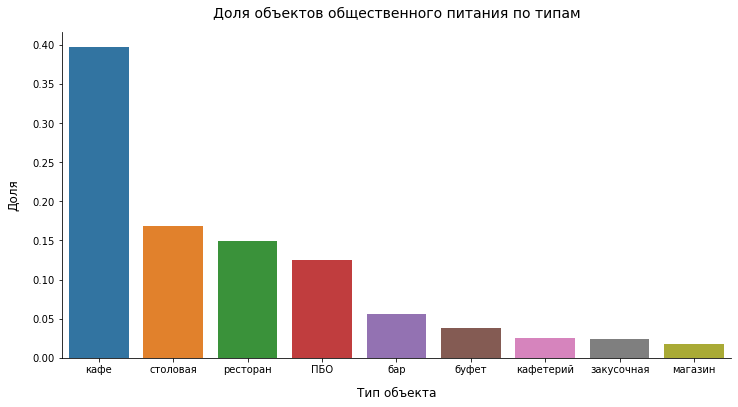

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(x=df['object_type'].value_counts(normalize=True).index, 
            y=df['object_type'].value_counts(normalize=True))
plt.title('Доля объектов общественного питания по типам', fontsize=14, pad=14)
plt.xlabel('Тип объекта', fontsize=12, labelpad=12)
plt.ylabel('Доля', fontsize=12, labelpad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() 
plt.show()

40% рынка заняты кафе, 17 и 15 процентов столовыми и ресторанами соотвественно, предприятия быстрого обслуживания занимают 13% рынка 

### По принадлежности к сети<a id="stage_2_distr_chain"></a>

Выясним количество сетевых заведений среди всех объектов

In [12]:
df.pivot_table(index='chain', values='id', aggfunc='count').reset_index()

,chain,id
0,да,2968
1,нет,12398


Всего в наших данных 2968 сетевых заведений и 12398 не сетевых, на графике это соотношение выглядит следующим образом

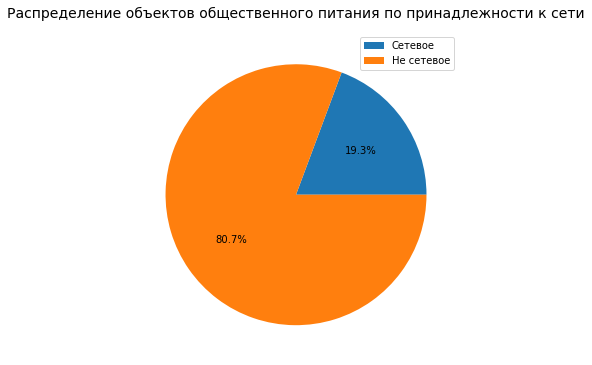

In [13]:
plt.figure(figsize=(12,6))
plt.pie(df.pivot_table(index='chain', values='id', aggfunc='count').reset_index()['id'],
        autopct="%.1f%%")
plt.legend(['Сетевое','Не сетевое'])
plt.title('Распределение объектов общественного питания по принадлежности к сети', 
          fontsize=14, pad=14)
plt.show()

Создадим сводную таблицу с указанием доли сетевых заведений среди каждого типа объектов

In [14]:
chain_per_type = df.pivot_table(index=['object_type','chain'], 
                                values='id', aggfunc='count').reset_index()
chain_per_type['%'] = chain_per_type.apply(lambda x: round(x['id'] / chain_per_type[chain_per_type['object_type'] == x['object_type']]['id'].sum(), 2), axis=1)
chain_per_type = chain_per_type.sort_values('%', ascending=False)

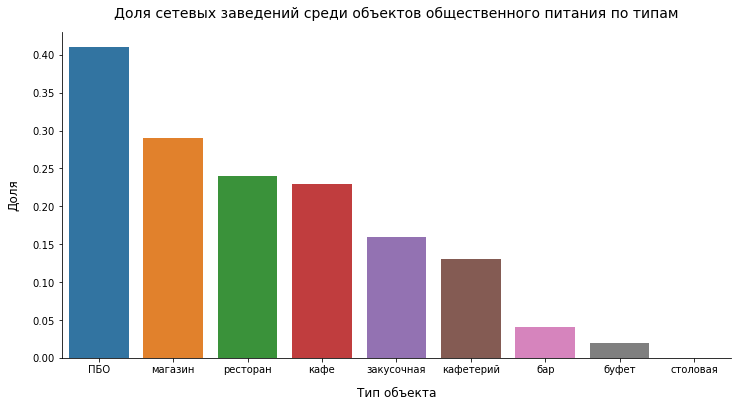

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(x=chain_per_type[chain_per_type['chain'] == 'да']['object_type'], 
            y=chain_per_type[chain_per_type['chain'] == 'да']['%'])
plt.title('Доля сетевых заведений среди объектов общественного питания по типам', fontsize=14, pad=14)
plt.xlabel('Тип объекта', fontsize=12, labelpad=12)
plt.ylabel('Доля', fontsize=12, labelpad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

Наибольшие доли сетевых заведений среди предприятий быстрого обслуживания (42%) и среди магазинов (29%)

## Размеры сетей<a id="stage_2_chains"></a>

Для оценки количества заведений в сетях заведений построим сводную таблицу

In [16]:
chains = df[df['chain'] == 'да'].pivot_table(index=['object_name'], 
                                             values=['id','number'], 
                                             aggfunc={'id':'count','number':'mean'}).reset_index()
chains.columns = ['object_name','count_id','mean_number']

In [17]:
len(chains)

724

Всего в нашем распоряжении имеются сведения о 724 сетях, оценим количество заведений в них, для этого выведем на экран размеры сетей отсортированные по убыванию заведений в сетях

In [18]:
chains['count_id'].value_counts().head()

1    450
2     99
3     44
4     24
5     21
Name: count_id, dtype: int64

Мы видим что 450 "сетей" включают в себя всего одно заведение, выведем часть из них на экран

In [19]:
chains[chains['count_id'] == 1]

,object_name,count_id,mean_number
0,Beverly Hills Diner,1,88.0
1,Bierloga,1,75.0
2,Black & White,1,40.0
4,BooBo,1,46.0
5,Bubbleology,1,6.0
...,...,...,...
718,кафе «Нияма»,1,80.0
719,кафе «Папа Джонс»,1,24.0
721,кафе «Шоколадница»,1,50.0
722,ресторан «Брудер»,1,86.0


Из реального мира мы знаем что "Шоколадница" и "Якитория" это крупные сети заведений, но в нашей группировке они отобразились как сети из всего одного заведения, выведем их на экран

In [20]:
df[np.logical_or(df['object_name'].str.find('Шоколадница') > 0, 
                 df['object_name'].str.find('Якитория') > 0)]

,id,object_name,chain,object_type,address,number
148,27207,ресторан «Якитория»,да,кафе,"город Москва, Валовая улица, дом 8/18",124
205,22005,Кафе «Якитория»,да,кафе,"город Москва, Волгоградский проспект, дом 15",158
591,134332,Кофейня «Шоколадница»,да,кафе,"город Москва, Ленинский проспект, дом 37А",43
700,142956,Ресторан «Якитория»,да,ресторан,"город Москва, проспект Мира, дом 97",25
764,25442,Кафе «Якитория»,да,кафе,"город Москва, Нижегородская улица, дом 2, корп...",106
887,21774,Кафе «Шоколадница»,да,кафе,"город Москва, улица Шаболовка, дом 30/12",48
1738,69008,Кафе «Шоколадница»,нет,кафе,"город Москва, Ломоносовский проспект, дом 25, ...",50
1819,76640,Ресторан «Якитория»,нет,ресторан,"город Москва, Шмитовский проезд, дом 16, строе...",139
1825,24304,Кафе «Шоколадница»,да,кафе,"город Москва, улица Большие Каменщики, дом 2",67
2940,19941,Кафе «Якитория»,да,кафе,"город Москва, улица Коштоянца, дом 2, корпус 1",101


Наблюдаются две проблемы: разный регистр и кавычки (их отсутствие в некоторых вариантах написания), исправим их

In [21]:
df['object_name'] = df['object_name'].str.upper()
df['object_name'] = df['object_name'].str.replace('«','')
df['object_name'] = df['object_name'].str.replace('»','')

Снова посчитаем количество сетей

In [22]:
chains = df[df['chain'] == 'да'].pivot_table(index=['object_name'], 
                                             values=['id','number'], 
                                             aggfunc={'id':'count','number':'mean'}).reset_index()
chains.columns = ['object_name','count_id','mean_number']

In [23]:
len(chains)

554

На 170 меньше, наши исправления повлияли на результат

In [24]:
chains['count_id'].value_counts().head()

1    306
2     76
3     47
6     21
5     17
Name: count_id, dtype: int64

Сетей из одного заведения все еще много, но, к сожалению, в нашем распоряжении, кроме наименования сети, которое может быть с ошибками, нет других сведений позволяющих идентифицировать принадлежность объекта к той или иной сети, для текущего анализа примем, что сети из одного заведения - на самом деле сети из одного заведения и не будем их учитывать при оценке распределения количества заведений и размера заведений среди сетей

In [25]:
chains = chains[chains['count_id'] > 1]

Выведем основную информацию о размере сети и о количестве посадочных мест среди сетевых заведений

In [26]:
pd.concat([chains['count_id'].describe(),
           chains['mean_number'].describe()], 
          keys=('Количество заведений',
                'Количество посадочных мест'), 
          axis=1).round()

,Количество заведений,Количество посадочных мест
count,248.0,248.0
mean,11.0,59.0
std,23.0,50.0
min,2.0,0.0
25%,2.0,21.0
50%,4.0,44.0
75%,7.0,85.0
max,157.0,259.0


Мы рассматриваем 248 сетей, в среднем, в каждой сети по 11 заведений на 59 посадочных мест, распределение по перцентилям показывает что 75% сетей укладываются в 7 заведений, а размер 75% заведений меньше 85 посадочных мест, построим диаграмму на которой отобразим это распределение

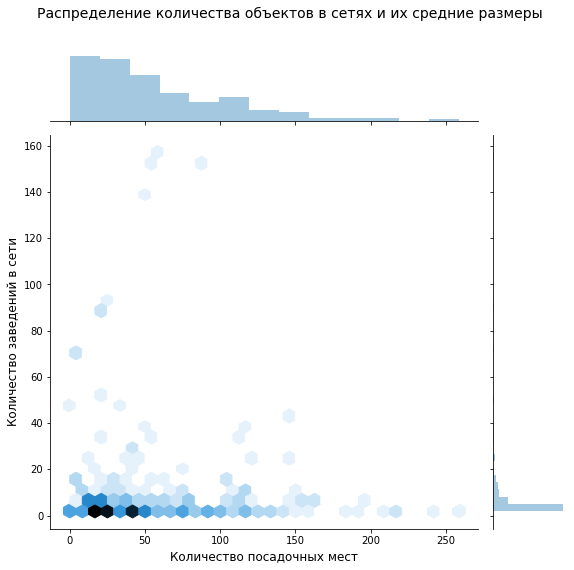

In [27]:
ax = sns.jointplot(x='mean_number', y='count_id', data=chains, height=8, kind='hex')
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Распределение количества объектов в сетях и их средние размеры', fontsize=14)
ax.set_axis_labels('Количество посадочных мест','Количество заведений в сети', fontsize=12)
plt.show()

На диаграмме значения сконцентрированы в левом нижнем углу - очень мало сетей количество заведений в которых превышает 10, распределение по количеству посадочных мест более широкое но наибольшая плотность наблюдается на левой стороне, до 50 посадочных мест на заведение

## Размеры заведений<a id="stage_2_size"></a>

Для сортировки таблицы по убыванию среднего количества заведений по типам объектов создадим сводную таблицу с этой информацией

In [28]:
mean_number_per_type = df.pivot_table(index='object_type', 
                                      values='number', aggfunc='mean').reset_index()
mean_number_per_type.columns = ['object_type','mean_number_per_type']

Присоединим ее к основной таблице

In [29]:
df = df.merge(mean_number_per_type, on='object_type', how='left')

Построим боксплоты распределений размера заведений по типам предваритеьно отсортировав таблицу df по убыванию среднего размера заведения

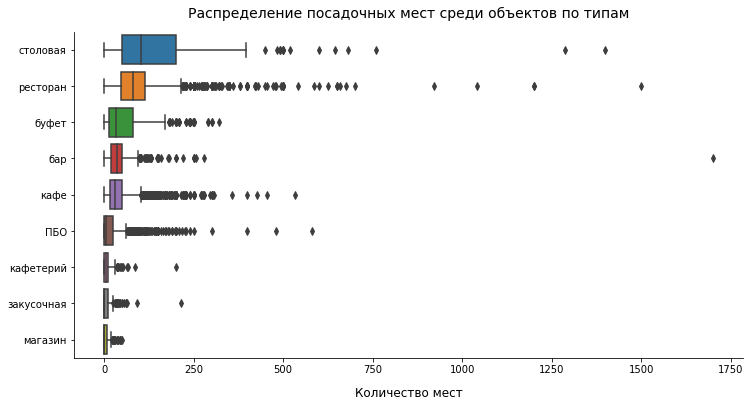

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(y=df.sort_values('mean_number_per_type', ascending=False)['object_type'], 
            x=df['number'], orient='h')
plt.title('Распределение посадочных мест среди объектов по типам', fontsize=14, pad=14)
plt.xlabel('Количество мест', fontsize=12, labelpad=12)
plt.ylabel(None)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()

Удалим временный столбец

In [31]:
df = df.drop('mean_number_per_type', axis=1)

Самыми крупными являются заведения типа столовых, ресторанов и буфетов, некоторые из них включают более 1000 мест, самыми небольшими являются кафетерии, закусочные и кулинарии при магазинах, примечательно что самым большим заведением является один из баров

Выведем на экран медианные размеры заведений по каждой категории так как в данных присутвует большое количество выбросов

In [32]:
df.pivot_table(index='object_type', values='number', 
               aggfunc=('median','mean')).sort_values('mean', ascending=False).round()

,mean,median
object_type,,
столовая,130.0,103.0
ресторан,97.0,80.0
буфет,51.0,32.0
бар,43.0,35.0
кафе,40.0,30.0
ПБО,21.0,5.0
кафетерий,9.0,6.0
закусочная,8.0,0.0
магазин,6.0,0.0


В категориях закусочная и кулинария при магазине медианное значение - 0, это означает что половина подобных заведений вообще не предполагет прием пищи в заведении и предлагает еду только на вынос

##  Улицы и районы с наибольшим количеством объектов<a id="stage_2_top_10"></a>

Для того чтобы выяснить на каких улицах расположено больше всего объектов воспользуемся методом `extract` которому передадим следующее регулярное выражение `', (.*?),'` оно ищет любые символы между запятыми в адресе

In [33]:
df['address_street'] = df['address'].str.extract(', (.*?),')
df.head()

,id,object_name,chain,object_type,address,number,address_street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,РОДНИК,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,КАФЕ АКАДЕМИЯ,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,КАФЕ ВИШНЕВАЯ МЕТЕЛЬ,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Проверим на всех ли адресах наш метод вернул название улицы

In [34]:
df[df['address_street'].isna()]

,id,object_name,chain,object_type,address,number,address_street
859,23601,БУФЕТ - ГБОУ СОШ № 64,нет,буфет,"Партизанская улица, дом 30",100,NaN
860,23604,БУФЕТ - ГБОУ 60,нет,буфет,"Партизанская улица, дом 30",100,NaN
7691,132359,КАФЕ LA CAROTTE,нет,кафе,"1-й Нагатинский проезд, дом 10",198,NaN
8813,145235,КАФЕ ПРИ АЗС,нет,кафе,"проезд Добролюбова, дом 2",0,NaN
8843,19760,БУФЕТ ПРИ А-С ЮГО-ЗАПАД,нет,буфет,"Ленинский проспект, владение 164",16,NaN
8854,140002,РЕСТОРАН ПАЛЬМИРА,нет,ресторан,"Новоданиловская набережная, дом 6",80,NaN
8860,83951,БУНКЕР 42 НА ТАГАНКЕ,нет,ресторан,"5-й Котельнический переулок, дом 11",271,NaN
8867,27866,СТОЛОВАЯ ГЕНШТАБА,нет,столовая,"улица Знаменка, дом 14",90,NaN
8875,149863,ШКОЛЬНО-БАЗОВАЯ СТОЛОВАЯ,нет,столовая,"Полевая улица, дом 20",205,NaN
8890,125478,ХИЖИНА,да,ресторан,"Чертановская улица, владение 32Б",75,NaN


Среди адресов объектов встречаются те, в которых не указан город, так как данные в нашем распоряжении из города Москвы - добавим их к адресу и снова применим метод `extract`

In [35]:
df.loc[df['address_street'].isna(), 'address'] = 'город Москва, ' + df['address']
df['address_street'] = df['address'].str.extract(', (.*?),')

Создадим сводную таблицу по улицам и отсортируем ее по возрастанию

In [36]:
df.pivot_table(index='address_street', values='id', aggfunc='count').\
   sort_values('id', ascending=False).head(10)

,id
address_street,
город Зеленоград,232
проспект Мира,204
Профсоюзная улица,182
Ленинградский проспект,171
Пресненская набережная,167
Варшавское шоссе,162
Ленинский проспект,148
поселение Сосенское,138
проспект Вернадского,132


Среди ТОП10 улиц Москвы отобразились "город Зеленоград" и "поселение Сосенское", выведем их на экран

In [37]:
df[df['address_street'].isin(['город Зеленоград','поселение Сосенское'])]

,id,object_name,chain,object_type,address,number,address_street
1386,22331,СТОЛОВАЯ МИЭТ,нет,столовая,"город Москва, город Зеленоград, улица Юности, ...",56,город Зеленоград
1405,20199,ЭТО,нет,кафе,"город Москва, город Зеленоград, корпус 401",35,город Зеленоград
1406,68113,ФРЕНДС,нет,кафе,"город Москва, город Зеленоград, корпус 435",34,город Зеленоград
1407,20105,КАФЕ ГРАФ МОНТЕ-КРИСТО,нет,кафе,"город Москва, город Зеленоград, корпус 436",40,город Зеленоград
1408,22982,АЛЬФОРНО,нет,кафе,"город Москва, город Зеленоград, корпус 438",49,город Зеленоград
...,...,...,...,...,...,...,...
15137,209920,ДЮШЕС,да,ресторан,"город Москва, город Зеленоград, Проезд № 4806,...",100,город Зеленоград
15169,213387,COFIX,да,кафе,"город Москва, поселение Сосенское, Калужское ш...",15,поселение Сосенское
15183,205739,ПИЦЦА ПАОЛО И БЕНТО WOK,да,кафе,"город Москва, город Зеленоград, Панфиловский п...",30,город Зеленоград
15184,220587,ПИЦЦА ПАОЛО,да,кафетерий,"город Москва, город Зеленоград, корпус 1627",0,город Зеленоград


Эти два населенных пункта - из Новой Москвы, адрес объектов в городе Зеленограде не содержит улиц, а для объектов из поселения Сосенского, в соответствии с логикой работы нашего запроса, из адреса было взято первое совпадение которое содержало только указание на поселение, в любом случае, нас интересует только сам город Москва, исключим эти данные из группировки ТОП10

In [38]:
top10_street = df[~df['address_street'].isin(['город Зеленоград','поселение Сосенское'])].\
               pivot_table(index='address_street',values='id', aggfunc='count').\
               sort_values('id', ascending=False).head(10)
top10_street

,id
address_street,
проспект Мира,204
Профсоюзная улица,182
Ленинградский проспект,171
Пресненская набережная,167
Варшавское шоссе,162
Ленинский проспект,148
проспект Вернадского,132
Кутузовский проспект,114
Каширское шоссе,112


Построим гистограмму на которой отобразим это распределение

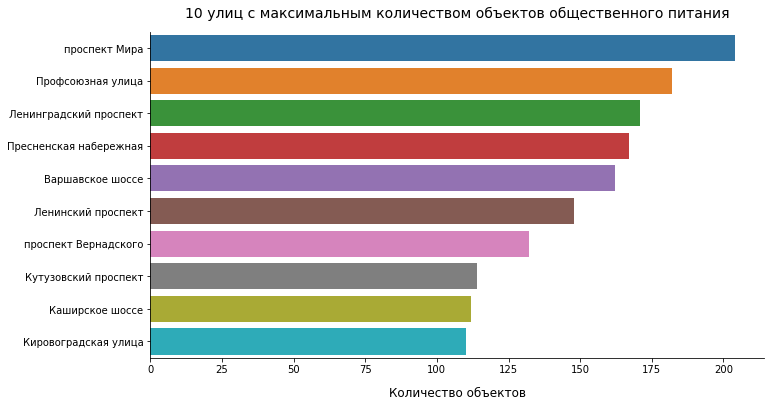

In [39]:
plt.figure(figsize=(11,6))
sns.barplot(y=top10_street.index, 
            x=top10_street['id'],
            orient='h')
plt.title('10 улиц с максимальным количеством объектов общественного питания', fontsize=14, pad=14)
plt.xlabel('Количество объектов', fontsize=12, labelpad=12)
plt.ylabel(None)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() 
plt.show()

Максимальное количество объектов находятся на улицах:
 * проспект Мира
 * Профсоюзная улица
 * Ленинградский проспект
 
Улицы из ТОП10 очень большие по протяженности, для ответа на вопрос в каких районах они пролегают нам понадобится получить данные с API Карт Яндекса

Подготовим данные для запроса

In [40]:
data_for_request_top_street = df[df['address_street'].isin(top10_street.index)][['id','address']]
data_for_request_top_street.head()

,id,address
151,155973,"город Москва, Варшавское шоссе, дом 2"
152,23618,"город Москва, Варшавское шоссе, дом 7, корпус 1"
153,155852,"город Москва, Варшавское шоссе, дом 29"
154,152556,"город Москва, Варшавское шоссе, дом 72, корпус 2"
155,120658,"город Москва, Варшавское шоссе, дом 100"


In [41]:
len(data_for_request_top_street)

1502

Всего у нас 1502 адреса для запроса

В отдельный проект мы импортировали библиотеку `requests` для запроса к API и библиотеку `re` для обработки ответа

Далее мы запустили два цикла:

В этом цикле мы передавали API адрес из подготовленных данных, из полученного ответа доставали регулярным выражением координаты объекта и сохраняли их в отдельный массив, после того как цикл закончил работу мы добавили данные массива `coord_list` в датафрейм `data_for_request`

Во втором цикле полученные ранее координаты мы передавали обратно API с указанием того что в ответе хотим получить район в который попали эти координаты, для этого в запросе мы применили специальный параметр `kind=district`, полученный массив адресов `district_list` мы также добавили в датафрейм `data_for_request`

Полученный массив данных мы сохранили на сервисах Google и готовы загрузить его в текущий проект, для этого импортируем необходимые библиотеки

Составим запрос и запишем ответ в датафрейм

In [42]:
district_top_street = pd.read_csv(BytesIO(requests.get('https://docs.google.com/spreadsheets/d/19TY-K9rYlN_ztAWBzBOqqQoeKZHoPcWBGC-4YPNywTo/export?format=csv').content))
district_top_street.head()

,id,address,coord,district
0,155973,"город Москва, Варшавское шоссе, дом 2",37.619683 55.699943,"Россия, Москва, Южный административный округ, ..."
1,23618,"город Москва, Варшавское шоссе, дом 7, корпус 1",37.622405 55.700877,"Россия, Москва, Южный административный округ, ..."
2,155852,"город Москва, Варшавское шоссе, дом 29",37.622792 55.693074,"Россия, Москва, Южный административный округ, ..."
3,152556,"город Москва, Варшавское шоссе, дом 72, корпус 2",37.618767 55.656839,"Россия, Москва, Южный административный округ, ..."
4,120658,"город Москва, Варшавское шоссе, дом 100",37.618812 55.646228,"Россия, Москва, Южный административный округ, ..."


Сведения о районе содержатся в составе адреса вместе с городом и административным округом, выделим из адреса только район

In [43]:
district_top_street['district'] = district_top_street['district'].str.split(',(.*?)', expand=True)[6]
district_top_street.head()

,id,address,coord,district
0,155973,"город Москва, Варшавское шоссе, дом 2",37.619683 55.699943,Донской район
1,23618,"город Москва, Варшавское шоссе, дом 7, корпус 1",37.622405 55.700877,Донской район
2,155852,"город Москва, Варшавское шоссе, дом 29",37.622792 55.693074,Донской район
3,152556,"город Москва, Варшавское шоссе, дом 72, корпус 2",37.618767 55.656839,Нагорный район
4,120658,"город Москва, Варшавское шоссе, дом 100",37.618812 55.646228,Нагорный район


Проверим на пропуски

In [44]:
district_top_street[district_top_street['district'].isna()]

,id,address,coord,district


Пропусков нет, построим сводную таблицу уже по районам

In [45]:
district_top_street.pivot_table(index='district', values='id', aggfunc='count').\
                    sort_values('id', ascending=False).head(10)

,id
district,
Пресненский район,167
район Чертаново Центральное,92
район Тропарёво-Никулино,89
район Аэропорт,65
Обручевский район,64
Мещанский район,63
район Свиблово,62
район Дорогомилово,61
район Нагатино-Садовники,57


Самым популярным районом для заведений общественного питания является Пресненский район, который расположен в центре города и, по сведениям из открытых источников является элитныым районом и туристическим центром, где расположены Государственный музей искусства народов Востока и тихие Патриаршие пруды. На территории района находятся Московский зоопарк и Московский планетарий с интерактивным музеем. На Большой Никитской улице расположены рестораны европейской и фьюжн-кухни, а также Московский академический театр имени Владимира Маяковского.

Кроме Пресненского района в центре города расположен Мещанский, остальные районы из ТОП10 ничем особо не примечательны.

##  Улицы и районы с наименьшим количеством объектов<a id="stage_2_low_10"></a>

Выделим из дата фрейма улицы на которых расположен всего один объект общественного питания

In [46]:
low_street = df.pivot_table(index='address_street',values='id', aggfunc='count')
low_street = low_street[low_street['id'] == 1]
low_street

,id
address_street,
1-й Балтийский переулок,1
1-й Басманный переулок,1
1-й Ботанический проезд,1
1-й Вешняковский проезд,1
1-й Голутвинский переулок,1
...,...
улица Шеногина,1
улица Шумилова,1
улица Шумкина,1


Всего у нас 570 таких улиц, для того чтобы выяснить в каких районах они расположены составим аналогичный запрос к API Карт Яндекса

Данные для запроса

In [47]:
data_for_request_low_street = df[df['address_street'].isin(low_street.index)][['id','address']]
data_for_request_low_street

,id,address
19,153644,"город Москва, Филипповский переулок, дом 15/5"
61,21214,"город Москва, Бабаевская улица, дом 3"
69,22139,"город Москва, 1-й Балтийский переулок, дом 3/25"
81,25833,"город Москва, улица Демьяна Бедного, дом 4"
131,150881,"город Москва, Будайская улица, дом 3"
...,...,...
14227,208805,"город Москва, 3-й Угрешский проезд, дом 8, стр..."
14440,211368,"город Москва, улица Линии Октябрьской Железной..."
14462,216767,"город Москва, 80-й километр Московской Кольцев..."
14704,214324,"город Москва, 2-й Кадашёвский переулок, дом 16..."


Импорт результата запроса

In [48]:
district_low_street = pd.read_csv(BytesIO(requests.get('https://docs.google.com/spreadsheets/d/1ReH4CBsvV5ooPlGp7GJrl8PkhypOC69qsiMXOZgRzP4/export?format=csv').content))

Выделим из адреса район

In [49]:
district_low_street['district'] = district_low_street['district'].str.split(',(.*?)', expand=True)[6]
district_low_street.head()

,id,address,coord,district
0,153644,"город Москва, Филипповский переулок, дом 15/5",37.598573 55.75058,район Арбат
1,21214,"город Москва, Бабаевская улица, дом 3",37.689069 55.790595,район Сокольники
2,22139,"город Москва, 1-й Балтийский переулок, дом 3/25",37.518785 55.810471,район Аэропорт
3,25833,"город Москва, улица Демьяна Бедного, дом 4",37.48693 55.770401,район Хорошёво-Мнёвники
4,150881,"город Москва, Будайская улица, дом 3",37.665156 55.831903,район Ростокино


Проверим на пропуски

In [50]:
district_low_street[district_low_street['district'].isna()]

,id,address,coord,district
306,23249,"город Москва, 104-й километр Московской Кольце...",0 0,NaN
339,25516,"город Москва, 42-й километр Московской Кольцев...",0 0,NaN
350,19912,"город Москва, 56-й километр Московской Кольцев...",0 0,NaN
354,143079,"город Москва, 65-й километр Московской Кольцев...",0 0,NaN
355,144799,"город Москва, 67-й километр Московской Кольцев...",0 0,NaN
376,74990,"город Москва, 26-й километр Московской Кольцев...",0 0,NaN
390,25019,"Нижний Таганский тупик, дом 3, строение 1",55.098473 51.802992,None
417,80008,"улица Каманина, домовладение 11, строение 2",30.348621 53.937992,None
439,148031,"город Московский, улица Хабарова, дом 2",37.351896 55.593868,NaN
449,162646,"город Троицк, 42-й километр Калужского шоссе, ...",37.288771 55.454233,NaN


Так как API не смог определить координаты и/или районы по данным адресам - удалим их из таблицы

In [51]:
district_low_street = district_low_street.drop(district_low_street[district_low_street['district'].isna()].index)

Выведем на экран первые 10 записей этой таблицы, отсортированные по убыванию

In [52]:
district_low_street_pivot = district_low_street.pivot_table(index='district', values='id', aggfunc='count')
district_low_street_pivot.sort_values('id', ascending=False).head(10)

,id
district,
Таганский район,30
район Хамовники,27
Пресненский район,24
Басманный район,22
Тверской район,21
район Марьина Роща,17
район Сокольники,15
Мещанский район,14
район Замоскворечье,12


Посчитаем количество районов в которых нашлись улицы с одним объектом общественного питания

In [53]:
district_low_street['district'].nunique()

104

Все 570 улиц с одним объектом общественного питания расположены в 104 районах Москвы. Большая часть из которых является "спальными" районами, но среди них присутствуют и центральные районы в которых есть улицы с всего одним объектом общественного питания

##  Количество посадочных мест среди объектов на самых популярных улицах<a id="stage_2_sits"></a>

Выведем на экран основные статистические показатели распределения количества посадочных мест

In [54]:
df[df['address_street'].isin(top10_street.index)]['number'].describe().round()

count    1502.0
mean       58.0
std        90.0
min         0.0
25%        12.0
50%        40.0
75%        75.0
max      1700.0
Name: number, dtype: float64

Среднее значение 58, медианное 40, 75% заведений рассчитаны на 75 и меньше посадочных мест

Построим гистограмму распределения и боксплот под ней для того чтобы наглядно продемонстировать какая часть гистограммы содержит выбросы

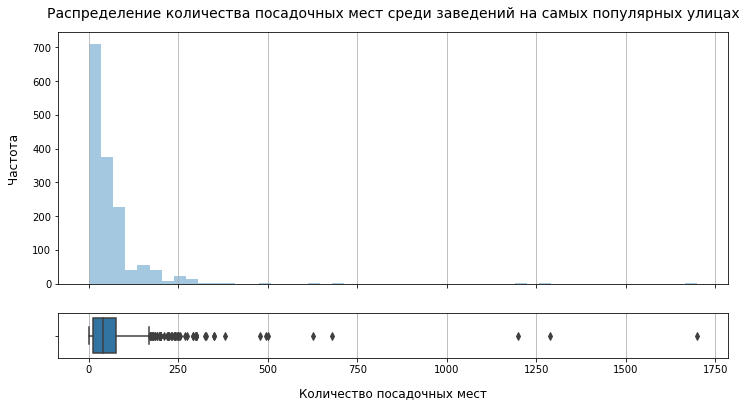

In [55]:
figure, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.85, 0.15)},
                                         figsize=(12,6))
sns.boxplot(df[df['address_street'].isin(top10_street.index)]['number'], ax=ax_box)
sns.distplot(df[df['address_street'].isin(top10_street.index)]['number'], kde=False, ax=ax_hist)
ax_hist.set_title('Распределение количества посадочных мест среди заведений на самых популярных улицах', fontsize=14, pad=14)
ax_hist.set_ylabel('Частота', fontsize=12, labelpad=12)
ax_hist.set_xlabel(None)
ax_hist.grid(axis='x')
ax_box.set_xlabel('Количество посадочных мест', fontsize=12, labelpad=12)
ax_box.grid(axis='x')
plt.show()

Правая граница ящика расположена на 75, левая, включающая оставшиеся 23% заканчивается на 150 а дальше идет 2% выбросов

Построим боксплоты распределний для сетевых и не сетевых заведений

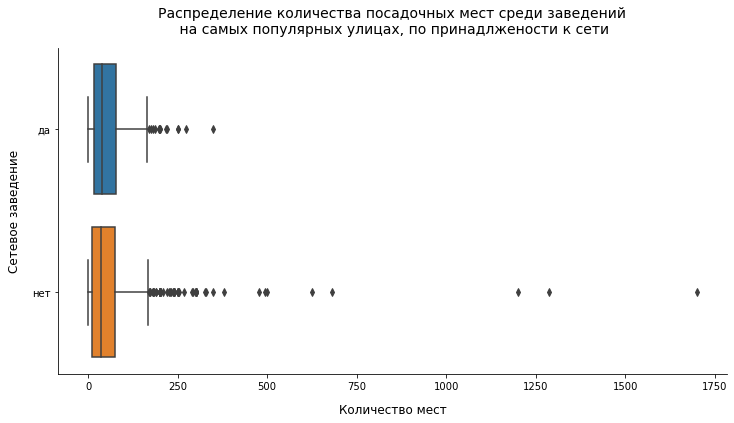

In [56]:
plt.figure(figsize=(12,6))
sns.boxplot(y=df[df['address_street'].isin(top10_street.index)]['chain'],
            x=df[df['address_street'].isin(top10_street.index)]['number'])
plt.title('Распределение количества посадочных мест среди заведений\n на самых популярных улицах, по принадлжености к сети', fontsize=14, pad=14)
plt.xlabel('Количество мест', fontsize=12, labelpad=12)
plt.ylabel('Сетевое заведение', fontsize=12, labelpad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

Распределения количества мест, за исключением большого количества выбросов среди не сетевых заведений, схожи

Выбросы можно объяснить тем что среди не сетевых заведений гораздо больше вариативность

Для вывода распределения посадочных мест по типам необходимо отсортировать датафрейм по возрастанию среднего количества посадочных мест среди объектов на самых популярных улицах, рассчитаем нужные данные и присоединим их к датафрейму

In [57]:
mean_number_per_type = df[df['address_street'].isin(top10_street.index)].\
                       pivot_table(index='object_type', 
                                   values='number', aggfunc='mean').reset_index()
mean_number_per_type.columns = ['object_type','mean_number_per_type']
df = df.merge(mean_number_per_type, on='object_type', how='left')

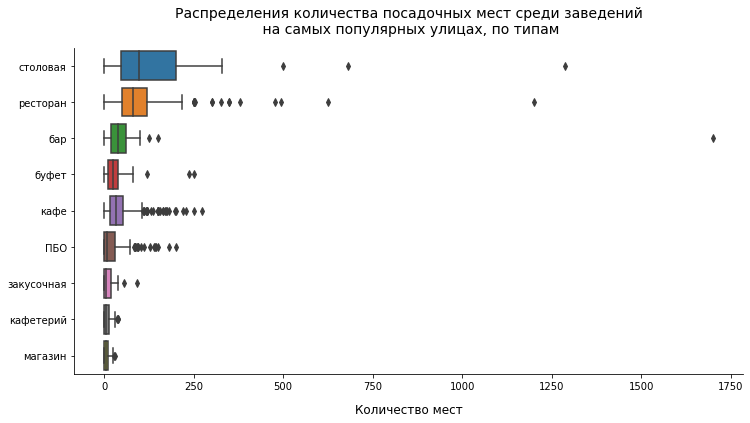

In [58]:
plt.figure(figsize=(12,6))
sns.boxplot(y=df[df['address_street'].isin(top10_street.index)].\
            sort_values('mean_number_per_type', ascending=False)['object_type'], 
            x=df[df['address_street'].isin(top10_street.index)]['number'], orient='h')
plt.title('Распределения количества посадочных мест среди заведений\n на самых популярных улицах, по типам', fontsize=14, pad=14)
plt.xlabel('Количество мест', fontsize=12, labelpad=12)
plt.ylabel(None)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

Снова удалим временный столбец

In [59]:
df = df.drop('mean_number_per_type', axis=1)

Распределения посадочных мест по типам заведений схожи с соответствующими распределениями в остальном городе, но выбросов гораздо меньше (за счет меньшего количества объектов)

## Вывод<a id="stage_2_summary"></a>

Анализ предоставленных данных позволил сделать следующие выводы

40% рынка заняты кафе, 17% и 15% столовыми и ресторанами, предприятия быстрого обслуживания занимают только 13% рынка

В городе находится 2968 (19,3%) сетевых заведений и 12398 (80,7%) не сетевых, наибольшие доли сетевых заведений среди предприятий быстрого обслуживания (42%) и среди кулинарий при магазинах (29%)

Медианные характеристики сетей заведений выглядят следующим образом:
* размер сети - 4 заведения
* размер заведения - 44 посадочных места

Сети состоящие более чем из 7 заведений составляют всего 25% от общего количества сетей

Анализ количества посадочных мест по типам объектов общественного питания показал что самыми крупными являются заведения типа столовых, ресторанов и буфетов, некоторые из них способны принять более 1000 посетителей, самыми небольшими являются кафетерии, закусочные и кулинарии при магазинах, примечательно что самым большим заведением является один из баров. В категориях закусочная и кулинария при магазине медианное значение количества мест - 0, это означает что половина подобных заведений вообще не предполагет прием пищи в них и предлагает еду только на вынос

Количество завдений в разрезе улиц и районов следующее: максимальное количество объектов находится на улицах проспект Мира, Профсоюзная улица и Ленинградский проспект. После того как мы провели анализ районов, в которых проходят 10 самых популярных улиц мы пришли к выводу что больше всего заведений общественного питания находится в Пресненском районе, который расположен в центре города и, по сведениям из открытых источников, является элитныым районом и туристическим центром

Далее мы провели анализ улиц, на которых расположено всего по одному объекту общественного питания, всего таких улиц нашлось 570, которые расположены в 104 районах городы Москвы, кроме большого количества спальных районов мы увидели некоторое количество райнов в центре города, на улицах которых расположено всего по одному объекту общественного питания

Срез заведений общественного питания на самых популярных улицах по количеству посадочных мест показал что среднее количетсво посадочных мест в них 58, 75% заведений рассчитаны на 75 и меньше посадочных мест. Распределения количества мест в сетевых и не сетевых заведениях схожи. Анализ размеров заведений по типам показал что в их размер схож с соответствующими типами во всем остальном городе.

# Этап 3 - Рекомендации<a id="stage_3"></a>
Объект который мы планируем открыть относится к категории экспериментальных и рассчитаных больше на туристическую аудиторию чем нам постоянных жителей столицы, в связи с этим рекомендуем рассмотреть для заведения место в одном из центральных районов, с большим количеством туристических объектов вокруг. Размеры помещений в центре города ограничены, разумным решением будет открыть небольшое кафе на 50 посадочных мест.

Если открытое заведение покажет хорошие показатели по посещаемости то можно рассмотреть открытие небольшой сети из кафе связанной тематики, но в первую очередь всегда стоит рассматривать размещение новых кафе вокруг объектов притягивающих большое количество туристов

# Общий вывод<a id="conclusion"></a>

Анализ рынка общественного питания происходил в несколько этапов, сначала мы загрузили данные и проверили их на ошибки, ошибок не было обнаружено, в процессе подготовки данных к анализу мы изменили два названия категорий заведений общественного питания:
* "предприятие быстрого обслуживания" - "ПБО"
* "магазин (отдел кулинарии)" - "магазин"

После этого мы приступили к анализу имеющейся информации.

Всего, на территории города расположены 15366 объектов общественного питания, из которых 40% это кафе

Сетевые заведения составляют всего 19,3% от общего количетсва объектов и самая большая доля их приходится на предприятия быстрого обслуживания - среди них 42% заведений относятся к различным сетям

При описании сетей заведений лучше рассматривать медианные характеристики, так как среди сетей находится большое количество малых (75% состоит из 7 и менее заведений) так и огромные сети больше чем на 100 объектов, разброс посадочных мест среди заведений входящих в сети тоже большой от 0 до 259, медианное количество не превышает 44 места, среднее 59

В разрезе типов объектов самыми крупными заведениями (по количеству мест) оказались столовые, рестораны и буфеты, некоторые из них способны вместить более 1000 гостей, самые небольшие: кафетерии, закусочные и кулинарии при магазинах. В категориях закусочная и кулинария при магазине медианное значение количества мест - 0, половина подобных заведений вообще не предполагет прием пищи в них и предлагает еду только на вынос

Анализ количества объектов в разрезе улиц и районов показал что, максимальное количество объектов находятся на улицах проспект Мира, Профсоюзная улица и Ленинградский проспект. После того как мы провели анализ районов, в которых проходят 10 самых популярных улиц мы пришли к выводу что больше всего заведений общественного питания находится в Пресненском районе

Далее мы провели анализ улиц, на которых расположено всего по одному объекту общественного питания, всего таких улиц нашлось 570, которые расположены в 104 районах городы Москвы, кроме большого количества спальных районов мы увидели некоторое количество райнов в центре города, на улицах которых расположено всего по одному объекту общественного питания

Проведенный анализ мест общественного питания на самых популярных улицах показал что среднее количество посадочных мест в них 58. Распределения количества посадочных мест в сетевых и не сетевых заведениях схожи. Оценка данного показателя в разрезе типов заведений показала что в центре города  меньше выбросов в распределениях количества мест по заведеням

По итогам анализа нами были выдвинуты следующие рекомендации:

* место размещения объекта - центральные районы содержащие объекты привлекающие туристов
* категория объекта - кафе
* размеры помещения - 50 посадочных мест
* возможность развития сети - в случае успеха первого объекта с учетом предыдущих рекомендаций

Презентация: https://drive.google.com/file/d/1i-9UijpWUP5pThdXlrG2MrTVCtTSSMGP/view?usp=sharing